In [2]:
import numpy as np
from copy import copy
import matplotlib.pyplot as plt
from numba import njit, prange

up =  "\u2191"  # ↑
down = "\u2193"  # ↑

boundary_conditions = {
     "periodic",
     "aperiodic",
     "buffered",
     "random",
}    
    
#TODO: add glass 
magnetic_character = {
    "ferromagnetic": 1, 
    "antiferromagnetic": 1,     
    "paramagnetic":0
}

# TODO : optimize via prange 
# TODO : optimize iteration space 
@njit(fastmath=True)
def hamiltonian(spins,h,J)-> (float | int ):
    N = spins.shape[0]
    energy_values = N**2//2
    interaction_energy = np.zeros((energy_values,energy_values))
    h_energy = np.sum(spins*h)
    for i in prange(N):
        for j in  prange(i, N):
            spin = spins[i,j]
            neighbors = np.array([
                    spins[(i-1) % N, j],  # Top neighbor
                    spins[(i+1) % N, j],  # Bottom neighbor
                    spins[i, (j-1) % N],  # Left neighbor
                    spins[i, (j+1) % N]   # Right neighbor
                ])
            
            
            interaction_energy[i,j]= np.sum(J* neighbors*spin)
    interaction_energy = np.sum(interaction_energy)
    H = -1.0*(interaction_energy+h_energy)
    return H

@njit(fastmath=True, parallel=True )
def magnetization(configs: np.ndarray[:,:]) -> (float | int):
    n = configs.shape[0]
    L = configs.shape[1]
    N = L**2
    M_local = np.zeros(n)  # Store local values per thread
    for i in prange(n):
        M_local[i] = np.sum(configs[i])/(N)
    return np.sum(M_local) / n  # Efficient sum outside prange

@njit(fastmath=True, parallel=True)
def internal_energy_per_site(configs: np.ndarray, J: (int | float), h: (int | float)) -> (float | int):
    n = len(configs)
    N = configs[0].shape[1]**2
    U_local = np.zeros(n)  # Store local values per thread
    for i in prange(n):
        U_local[i] = hamiltonian(configs[i],h,J)/N
    return np.sum(U_local) / n  # Efficient sum outside prange

@njit(fastmath=True,parallel=True)
def ΔE(J,spins,i,j):
    N = spins.shape[0]
    si = spins[i,j]
    sj = np.array([
                spins[(i-1) % N, j],  # Top neighbor
                spins[(i+1) % N, j],  # Bottom neighbor
                spins[i, (j-1) % N],  # Left neighbor
                spins[i, (j+1) % N]   # Right neighbor
            ])
            
    interaction_energy = np.sum(2*J* si*sj)

    return interaction_energy

H = hamiltonian

#TODO: optimization 
@njit(fastmath=True)
def monte_carlo(lattice: np.ndarray[:,:],
                J=1.0,
                h=0.0 ,
                β=1.0,

                iterations: (int)= 100, 
                thermalization_steps : (int) = 10,
                sampling_interval: int = 10) -> np.ndarray[:,:]: 

    assert (iterations-thermalization_steps) % sampling_interval == 0 
    N = lattice.shape[0]
    config_n = iterations-thermalization_steps
    configurations = np.zeros((config_n//sampling_interval,N,N))
    for step in range(0,iterations):
   
        i,j = np.random.randint(0, N), np.random.randint(0, N)
        δE = ΔE(J,lattice,i,j)
        if δE < 0 or np.random.rand() < np.exp(-β * δE):
            lattice[i, j] *= -1.0  # Flip only if accepted
             # Store configurations at intervals to reduce memory usage

        if step > thermalization_steps and step % sampling_interval == 0:
            k = step // sampling_interval 
            configurations[k,:,:] = lattice
    return configurations


def jackknife_error(data: np.ndarray) -> tuple:
    """
    Compute the jackknife estimate of the mean and its standard error efficiently.

    Parameters:
        data (np.ndarray): Array of computed values (e.g., energy, magnetization).

    Returns:
        mean (float): The estimated mean.
        std_error (float): The jackknife standard error.
    """
    n = len(data)
    mean_full = np.mean(data)  # Compute full-sample mean

    # Preallocate NumPy array for jackknife means
    jackknife_means = np.zeros(n)

    # Compute leave-one-out means
    total_sum = np.sum(data)
    for i in range(n):
        jackknife_means[i] = (total_sum - data[i]) / (n - 1)

    # Compute variance
    mean_jackknife = np.mean(jackknife_means)
    variance = (n - 1) * np.mean((jackknife_means - mean_jackknife) ** 2)
    std_error = np.sqrt(variance)

    return mean_full, std_error

class SpinLattice():

    """ 
    
    
    """
    
    def __init__(self,
                 N: (int | float),
                dimension:(int) = 2 , 
                temperature:(int| float ) = 1 , 
                 boundary_condition: str="buffered",
                 spin_number:(int | float) = 1/2, 
                 scale_number:(int | float) = 2, 
                 buffer_pad: (int | float) = 0, 
                 interaction_strength: (int| float)= 1.0,
                 magnetic_strength: (int|float)=1.0 ,
                 seed: int = None):
                
                if seed != None:
                    np.random.seed(seed)

                self.inverse_temperature = 1/temperature
                self.β = 1/temperature
                self.dimension = dimension
                self.d = dimension
                self.N = N
                final_value = spin_number+.5 if spin_number%1 !=0 else spin_number+1
                spin_values = np.arange(-spin_number,final_value)*scale_number

                self.spins = np.random.choice(spin_values,size=(self.N,self.N))
                self.h = magnetic_strength
                self.bc = boundary_condition
                self.J = interaction_strength
                self.interaction_strength = interaction_strength

                if self.bc == "buffered":
                  #https://numpy.org/doc/stable/reference/generated/numpy.pad.html
                  self.spins = np.pad(self.spins, pad_width = 1)


    def __str__(self):
         spin_string = np.where(self.spins == 1, up, np.where(self.spins == -1, down, self.spins))
         return str(spin_string[1:self.N+1,1:self.N+1])




In [3]:
J = 1 
h = 0.0
L = 16
iterations = 500000
sampling_rate = 100
sample_n = iterations//sampling_rate
n_spins = L **2
burnin_fraction = .2
thermalization = int(sample_n*burnin_fraction)
Ts = np.arange(.1,3,.05)
Ms = np.zeros(len(Ts))
Es = np.zeros(len(Ts))

for t in range(len(Ts)):
    print(f"running T = {Ts[t]}...")
    lattice = SpinLattice(N=L, 
                          interaction_strength=J, 
                          magnetic_strength=h,
                          temperature=Ts[t],
                          boundary_condition=None)
    configs = monte_carlo(lattice.spins,
                          lattice.J,
                          lattice.h,
                          lattice.β, 
                          thermalization_steps=thermalization, 
                          iterations = iterations, 
                          sampling_interval=sampling_rate)
    n = len(configs)
    # slow down here 
    U = internal_energy_per_site(configs,J,h)
    # relatively fast 
    M = magnetization(configs)
    print(f"U(T={Ts[t]}):",U); print(f"M(T={Ts[t]}):",M)
    Ms[t] = M ; Es[t] = U
 
plt.style.use('ggplot') 
plt.figure(figsize=(10,5))
plt.scatter(Ts,Ms ,color="blue")
plt.plot(Ts,Es ,color="orange")
plt.xlabel("T")
plt.ylabel(f"|M|")
plt.title("2-D Ising Model: Magnetization and Energy")
plt.show() 



running T = 0.1...


: 

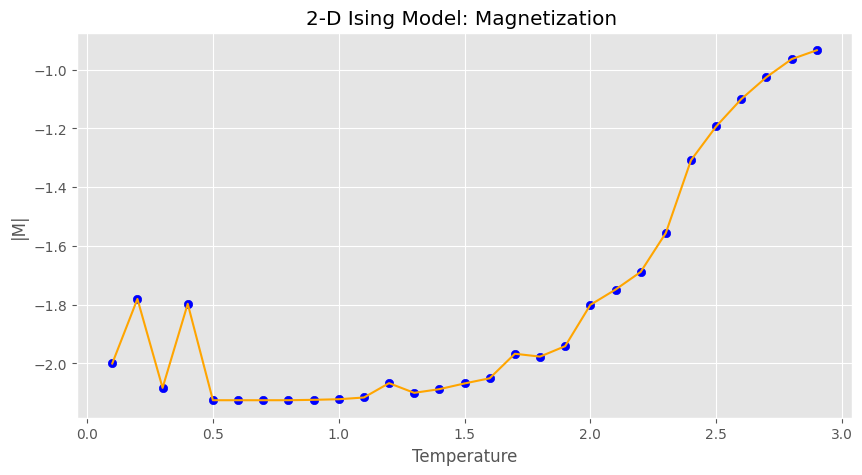

In [10]:
plt.style.use('ggplot') 
plt.figure(figsize=(10,5))
plt.scatter(Ts,Es ,color="blue")
plt.plot(Ts,Es ,color="orange")
# plt.grid()
plt.xlabel("Temperature")
plt.ylabel(r"|M|")
plt.title("2-D Ising Model: Magnetization ")
plt.show() 


In [4]:
lattice = SpinLattice(N=64, interaction_strength=1.0, magnetic_strength=0.0, temperature=1.0, boundary_condition=None)
configs = monte_carlo(lattice.spins, lattice.J, lattice.h, lattice.β, 1000,1)
# energies = [hamiltonian(lattice,J=1, h=0.0)/5000 for lattice in configs]


In [6]:
configs[0].shape

(64, 64)

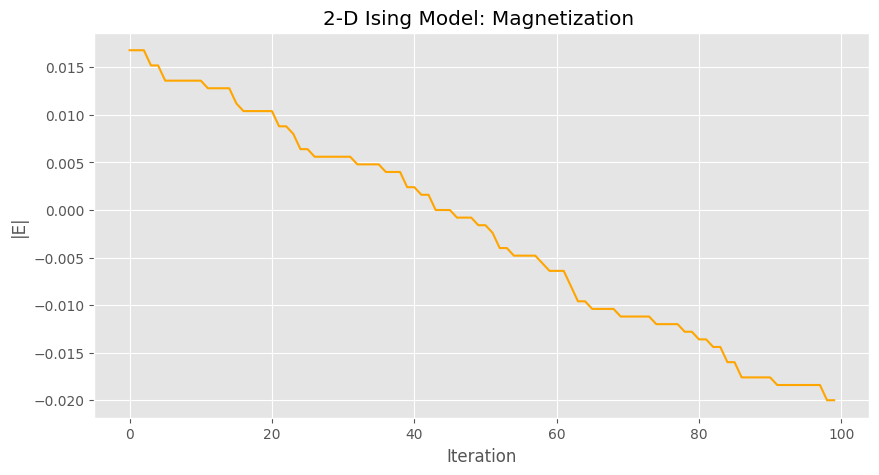

In [148]:
plt.style.use('ggplot') 
plt.figure(figsize=(10,5))
plt.plot(energies ,color="orange")
# plt.grid()
plt.xlabel("Iteration")
plt.ylabel(r"|E|")
plt.title("2-D Ising Model: Magnetization ")
plt.show() 

In [22]:
(iterations-thermalization) % sampling_rate 

0

In [131]:
2000000/2

1000000.0

In [120]:
iterations = 100000
sampling_rate = 5 
sample_n = iterations//sampling_rate
burnin_fraction = .2
start = sample_n*burnin_fraction
start

4000.0

In [93]:
len(configs)

10000

In [101]:
n = len(configs)
N = configs.shape[1]
np.sum([np.sum(c)/N for c in configs])/n

np.float64(-0.134759375)

In [127]:
1000000/5

200000.0

In [ ]:
internal_energy_per_site(configs,1,1)

In [7]:
for i in range(3):
    for j in range(i, 3):  # Only sum upper triangle (i < j)
        print(i,j)

0 0
0 1
0 2
1 1
1 2
2 2


In [3]:
lattice = SpinLattice(N=L, 
                          interaction_strength=J, 
                          magnetic_strength=h,
                          temperature=Ts[t],
                          boundary_condition=None)

In [ ]:
magnetization()

NameError: name 'start' is not defined

In [ ]:
hamiltonian(configs[0],1,1)

-244.0

In [19]:
internal_energy_per_site(configs,1,1)

-0.191072265625